In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import zipfile
zip_data = zipfile.ZipFile('/content/archive (8).zip','r')
zip_data.extractall('/content')
zip_data.close()

In [4]:
df=pd.read_csv('/content/train.csv')

In [6]:
df.head()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,0,1,0,1,0,1,0,1,...,f,?,no,no,Austria,no,6.351166,18 and more,Self,0
1,2,0,0,0,0,0,0,0,0,0,...,m,?,no,no,India,no,2.255185,18 and more,Self,0
2,3,1,1,1,1,1,1,1,1,1,...,m,White-European,no,yes,United States,no,14.851484,18 and more,Self,1
3,4,0,0,0,0,0,0,0,0,0,...,f,?,no,no,United States,no,2.276617,18 and more,Self,0
4,5,0,0,0,0,0,0,0,0,0,...,m,?,no,no,South Africa,no,-4.777286,18 and more,Self,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               800 non-null    int64  
 1   A1_Score         800 non-null    int64  
 2   A2_Score         800 non-null    int64  
 3   A3_Score         800 non-null    int64  
 4   A4_Score         800 non-null    int64  
 5   A5_Score         800 non-null    int64  
 6   A6_Score         800 non-null    int64  
 7   A7_Score         800 non-null    int64  
 8   A8_Score         800 non-null    int64  
 9   A9_Score         800 non-null    int64  
 10  A10_Score        800 non-null    int64  
 11  age              800 non-null    float64
 12  gender           800 non-null    object 
 13  ethnicity        800 non-null    object 
 14  jaundice         800 non-null    object 
 15  austim           800 non-null    object 
 16  contry_of_res    800 non-null    object 
 17  used_app_before 

In [8]:
df.shape

(800, 22)

In [9]:
df=df.drop(columns=['ID'])

# EDA

In [10]:


ints = []
objects=[]
floats=[]

for col in df.columns:
  if df[col].dtype == int:
    ints.append(col)
  elif df[col].dtype == object:
    objects.append(col)
  else:
    floats.append(col)

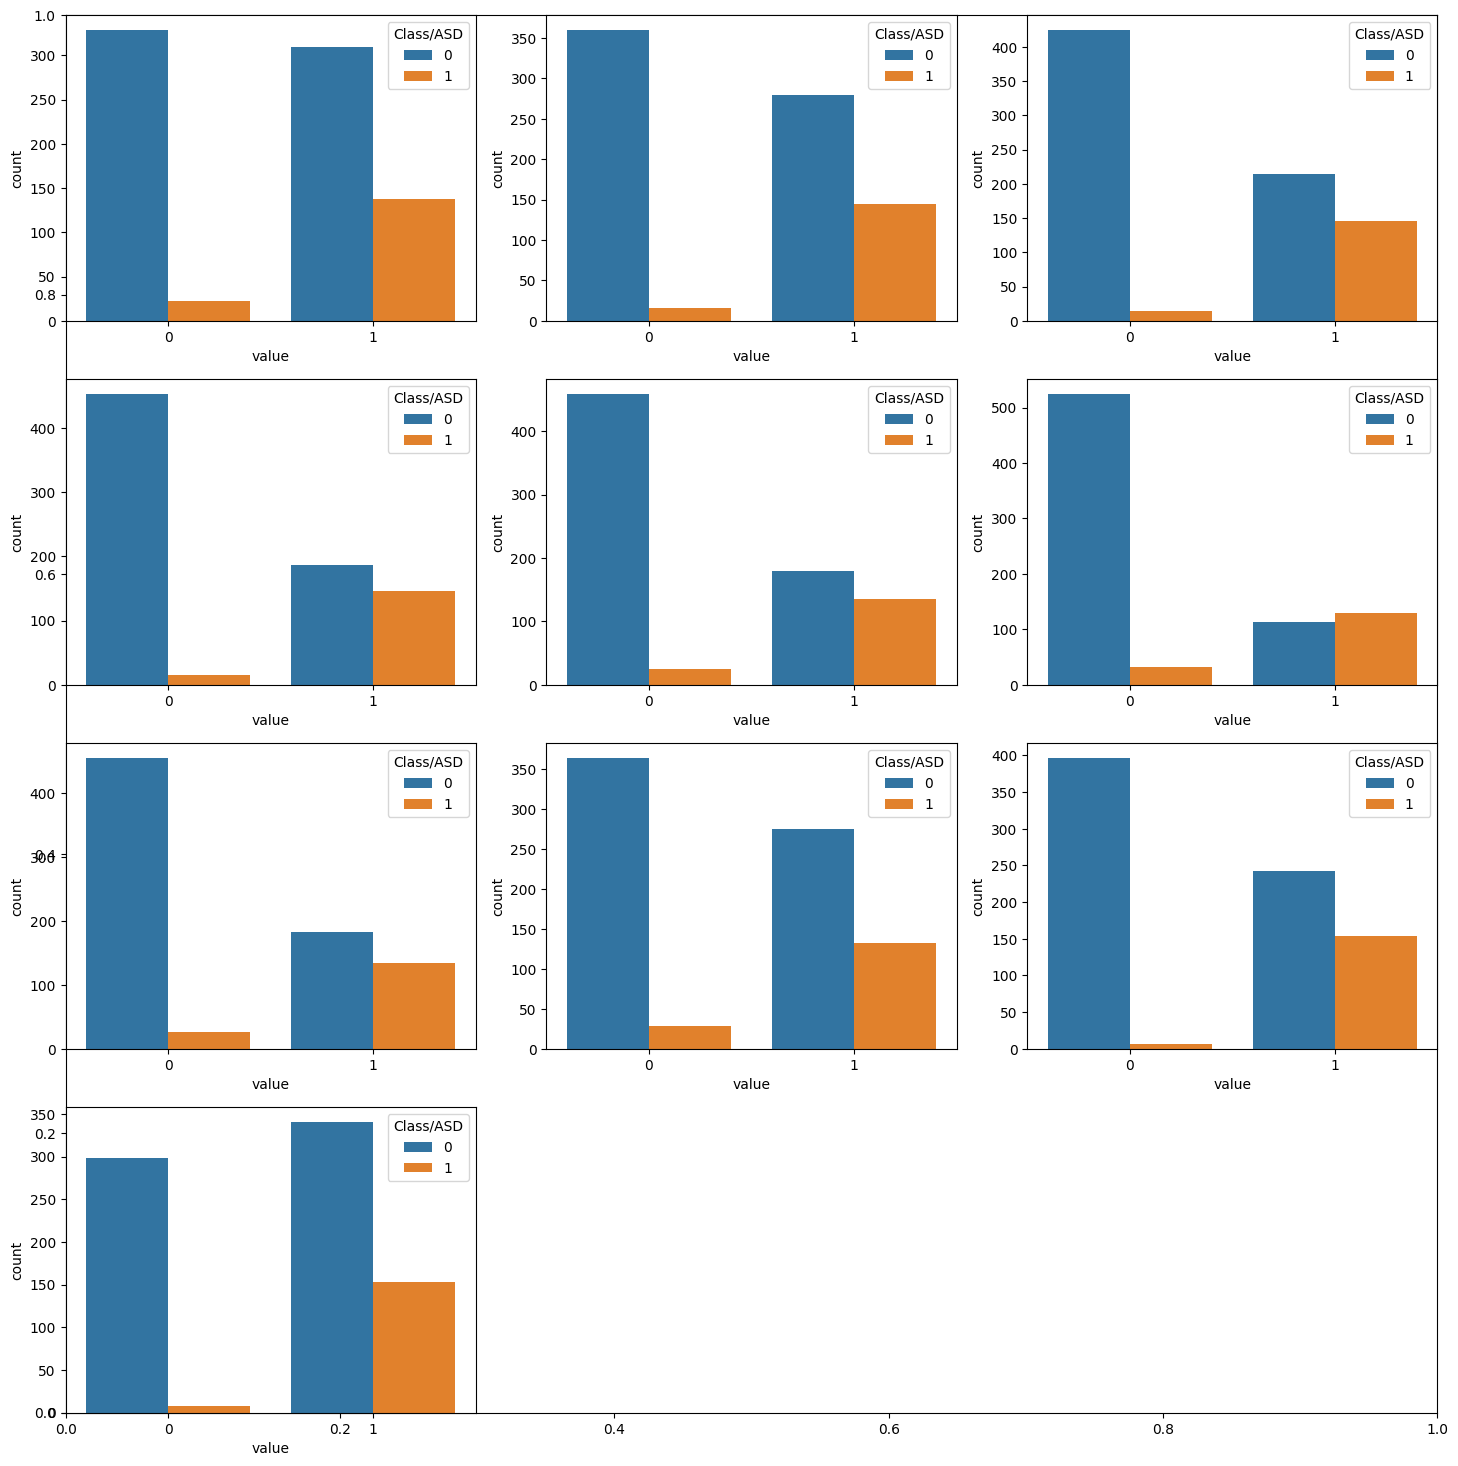

In [11]:

ints.remove('Class/ASD')

df_melted=df.melt(id_vars=['Class/ASD'],value_vars=ints,var_name='col',value_name='value')

plt.subplots(figsize=(15,15))

for i,col in enumerate(ints):
  plt.subplot(4,3,i+1)
  sns.countplot(x='value',hue='Class/ASD',data=df_melted[df_melted['col'] == col])

plt.tight_layout()
plt.show()

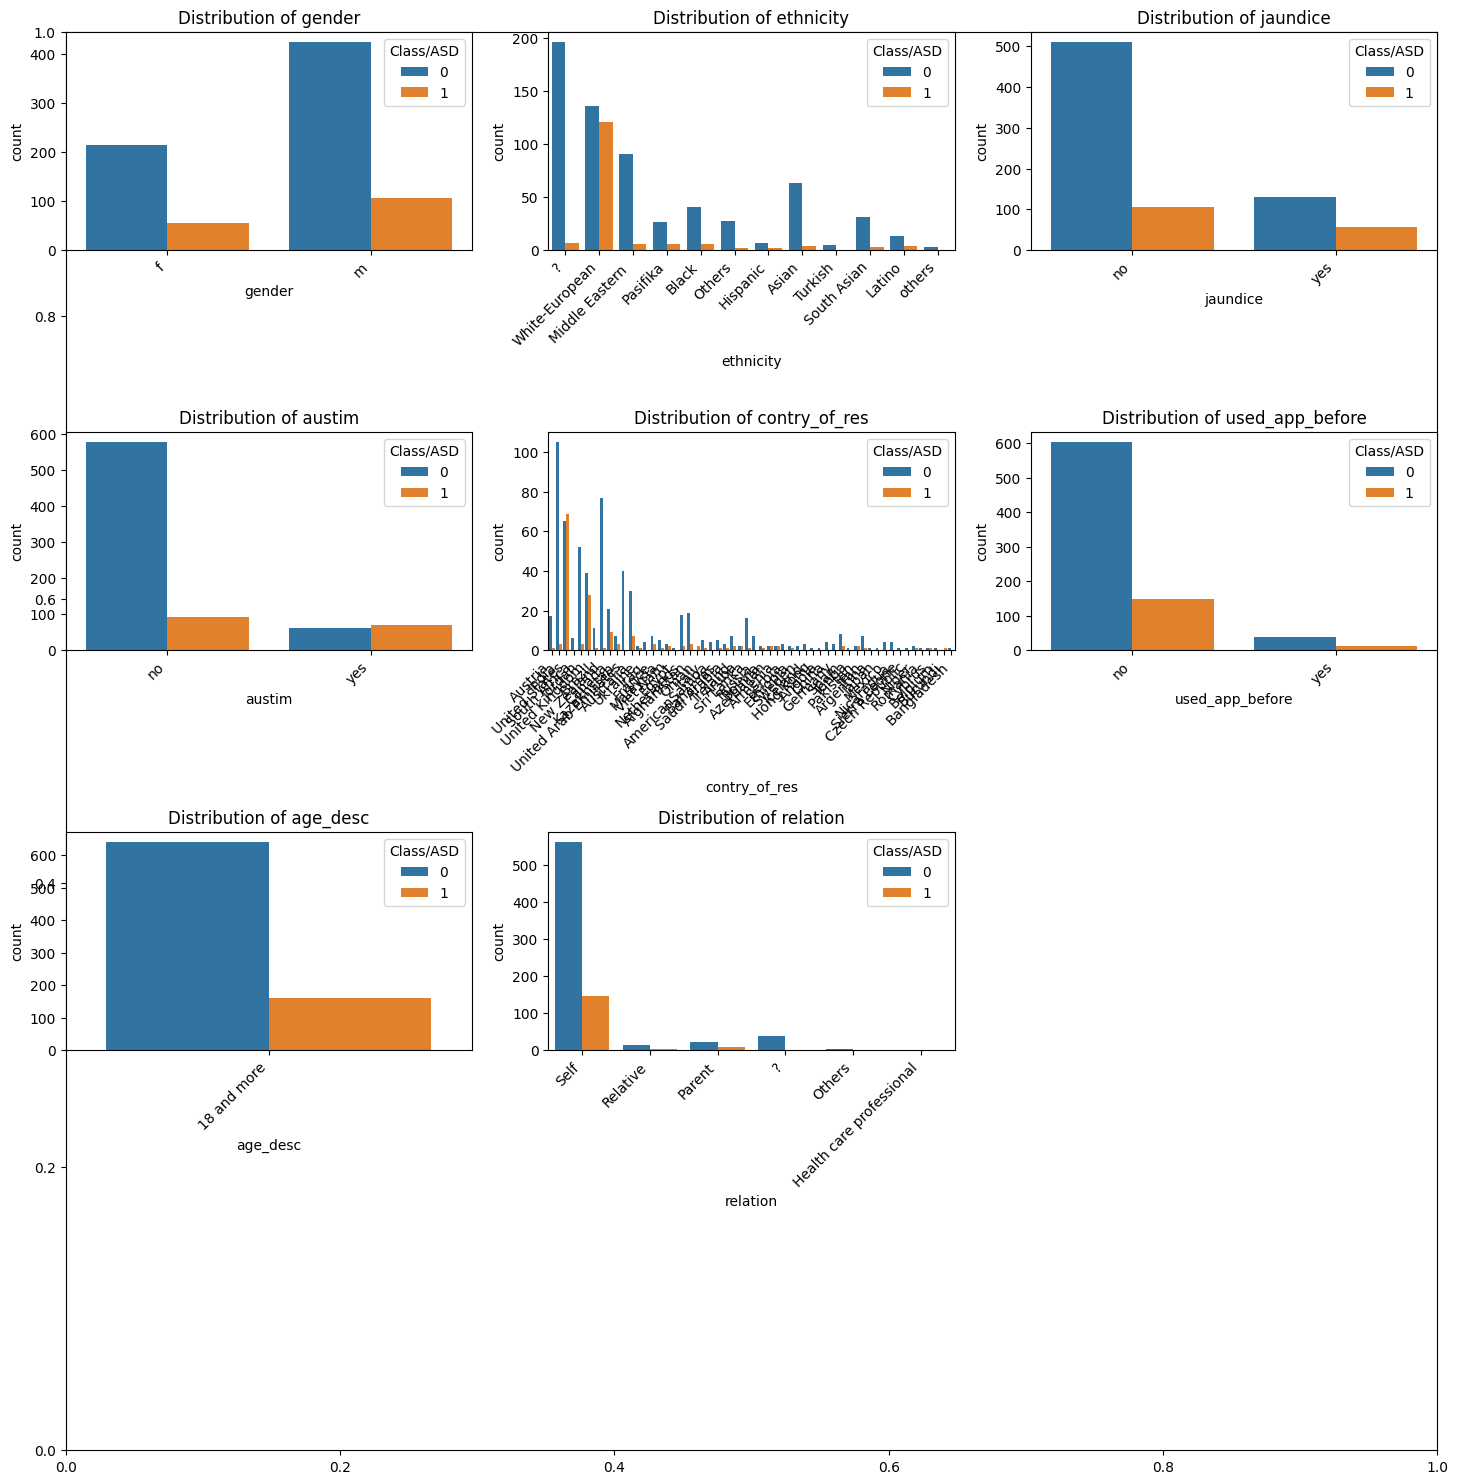

In [12]:

plt.subplots(figsize=(15,15))

for i,col in enumerate(objects):
  plt.subplot(4,3,i+1)
  sns.countplot(x=col,hue='Class/ASD',data=df)
  plt.title(f'Distribution of {col}')
  plt.xticks(rotation=45,ha='right')

plt.tight_layout()
plt.show()

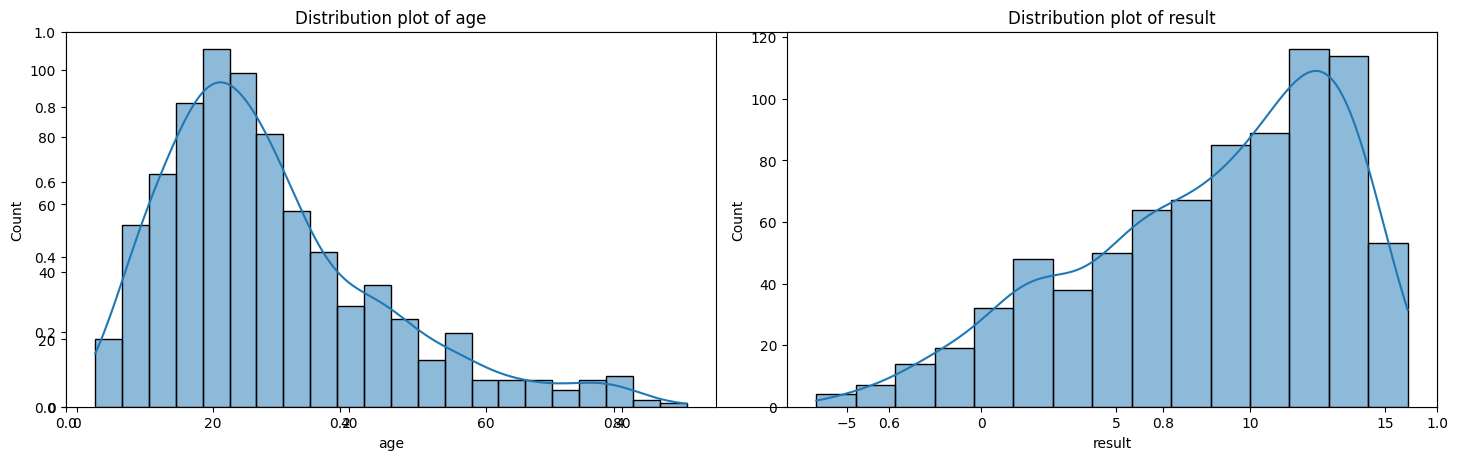

In [13]:


plt.subplots(figsize=(15,5))

for i,col in enumerate(floats):
  plt.subplot(1,2,i+1)
  sns.histplot(df[col],kde=True)
  plt.title(f'Distribution plot of {col}')

plt.tight_layout()
plt.show()


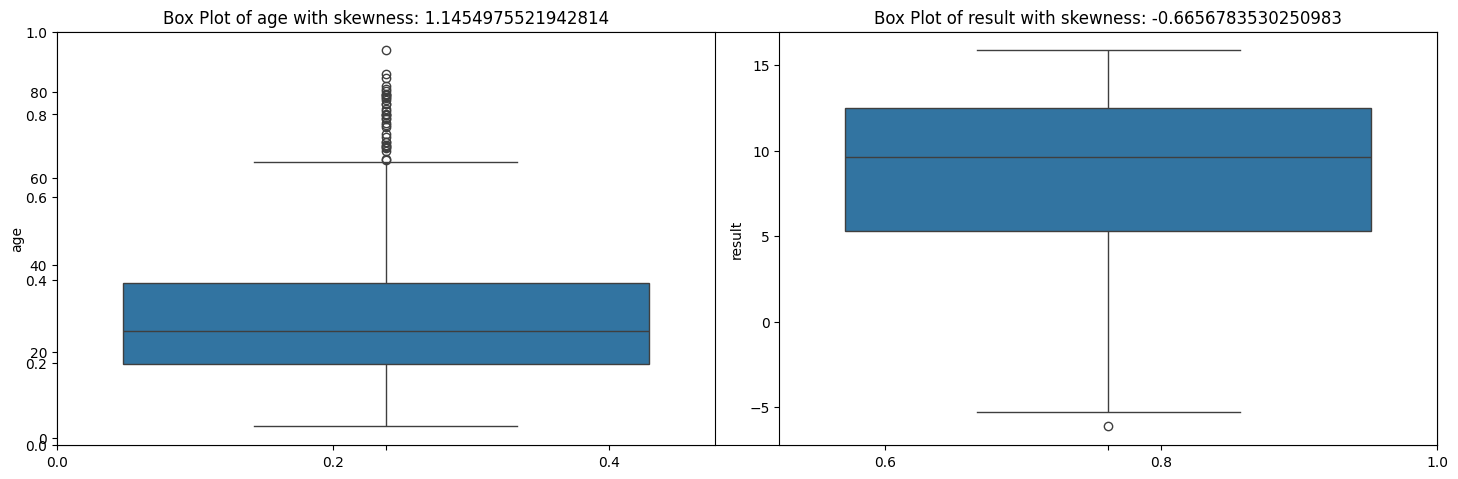

In [14]:

plt.subplots(figsize=(15,5))

for i,col in enumerate(floats):
  plt.subplot(1,2,i+1)
  sns.boxplot(df[col])
  plt.title(f'Box Plot of {col} with skewness: {df[col].skew()}')
plt.tight_layout()
plt.show()

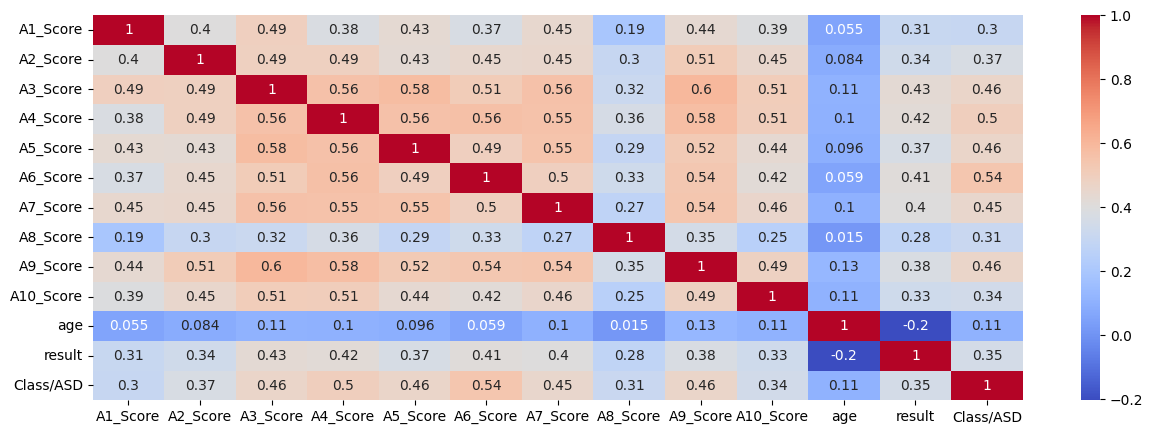

In [15]:
numerical_col=df.select_dtypes(include=['number']).columns
corr_matrix=df[numerical_col].corr()
plt.figure(figsize=(15,5))
sns.heatmap(corr_matrix,annot=True,cmap='coolwarm')
plt.show()

In [16]:
df = df.replace({'?':'Others', 'others':'Others'})


# Feature Engineering

**Normal transformation**

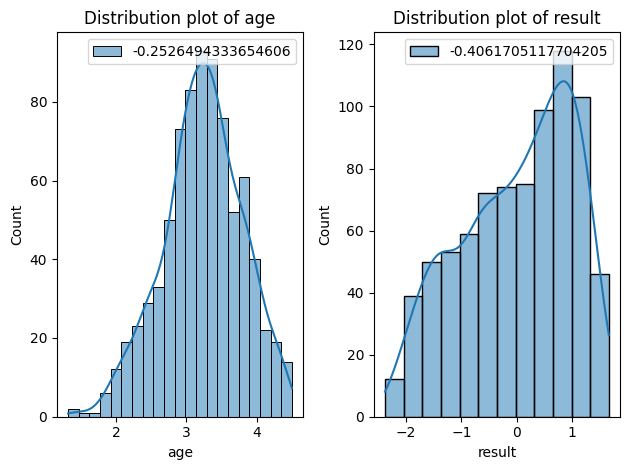

In [17]:
from sklearn.preprocessing import FunctionTransformer,PowerTransformer
from sklearn.compose import ColumnTransformer
trf = ColumnTransformer([
    ('power', PowerTransformer(), ['result']),
    ('log', FunctionTransformer(np.log1p, feature_names_out='one-to-one'), ['age'])
], remainder='passthrough', verbose_feature_names_out=False)

df_trf=trf.fit_transform(df)
df=pd.DataFrame(df_trf,columns=trf.get_feature_names_out())
for i,col in enumerate(floats):
  plt.subplot(1,2,i+1)
  sns.histplot(df[col],kde=True,label=df[col].skew())
  plt.title(f'Distribution plot of {col}')
  plt.legend()

plt.tight_layout()

plt.show()

**Feature Construction**

In [18]:

def convertAge(age):
  if age<4:
    return 'Toddler'
  elif age<12:
    return 'Kid'
  elif age<18:
    return 'Teenager'
  elif age<40:
    return 'Young'
  else:
    return 'Senior'

df['ageGroup']=df['age'].apply(convertAge)

<Axes: xlabel='ageGroup', ylabel='count'>

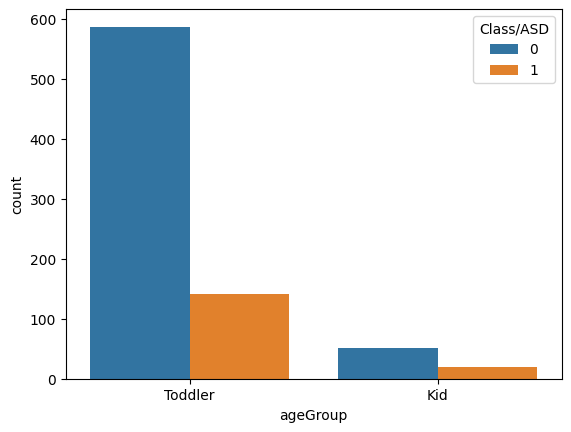

In [19]:
sns.countplot(x=df['ageGroup'],hue=df['Class/ASD'])

In [20]:
def add_feature(data):
  data['sum_score']=0
  for col in data.loc[:,'A1_Score':'A10_Score'].columns:

    data['sum_score']+=data[col]

  return data

df=add_feature(df)


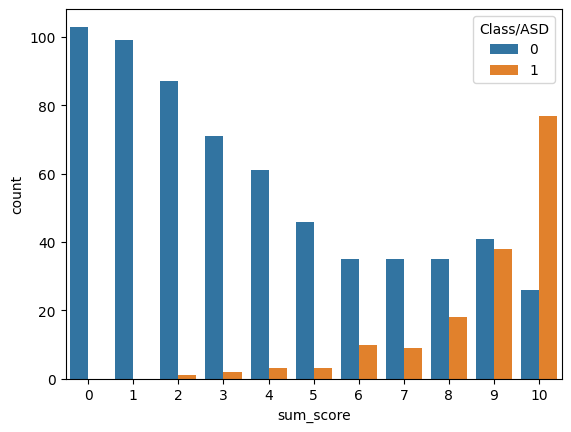

In [21]:
sns.countplot(x=df['sum_score'],hue=df['Class/ASD'])
plt.show()

In [22]:
from sklearn.model_selection import train_test_split
x=df.drop(columns=['Class/ASD'])
y=df['Class/ASD']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [23]:
x_train

,result,age,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,...,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,age_desc,relation,ageGroup,sum_score
264,0.839879,4.380018,1,1,1,1,1,1,1,1,...,m,White-European,no,yes,Canada,no,18 and more,Self,Kid,10
615,0.881368,2.350587,0,0,0,0,0,0,1,1,...,m,Black,no,no,New Zealand,no,18 and more,Others,Toddler,2
329,-0.757624,3.482049,1,0,0,0,0,0,0,0,...,m,Others,no,no,Jordan,no,18 and more,Self,Toddler,1
342,-0.165322,3.419817,0,0,0,0,0,0,0,0,...,m,Others,no,no,United Arab Emirates,no,18 and more,Self,Toddler,0
394,1.193288,3.435536,1,1,0,1,0,0,0,0,...,f,White-European,no,no,Canada,no,18 and more,Self,Toddler,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,-1.659501,4.049653,0,1,0,0,0,0,0,1,...,m,Asian,no,no,New Zealand,no,18 and more,Self,Kid,3
106,1.074874,2.991812,0,0,0,1,0,0,0,1,...,m,Others,no,no,Malaysia,yes,18 and more,Self,Toddler,3
270,0.960392,2.487401,1,0,0,0,1,0,0,1,...,f,Middle Eastern,no,no,United Arab Emirates,no,18 and more,Parent,Toddler,4
435,0.650281,3.771748,1,1,1,1,1,0,1,0,...,m,White-European,no,no,Australia,no,18 and more,Self,Toddler,8


**Encoding Variables**

In [24]:
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.compose import ColumnTransformer
le=LabelEncoder()
y_train=le.fit_transform(y_train)
y_test=le.transform(y_test)
categorical_features = objects + ['ageGroup']
trf=ColumnTransformer([
    ('ohe',OneHotEncoder(sparse_output=False,handle_unknown='ignore'),categorical_features)
],remainder='passthrough')

x_train=trf.fit_transform(x_train)
x_test=trf.transform(x_test)

**Feature Extraction**

In [25]:
x_train.shape

(640, 90)

In [26]:
from sklearn.decomposition import PCA


pca=PCA(n_components=10)
x_train=pca.fit_transform(x_train)
x_test=pca.transform(x_test)


**Feature Scaling**

In [27]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
x_train=sc.fit_transform(x_train)
x_test=sc.transform(x_test)

# Model Training

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score,recall_score,f1_score

lr=LogisticRegression()
lr.fit(x_train,y_train)
y_pred=lr.predict(x_test)

print('Accuracy',accuracy_score(y_test,y_pred))
print('Precision:',precision_score(y_test,y_pred))
print('Recall:',recall_score(y_test,y_pred))
print('F1 Score',f1_score(y_test,y_pred))
print('Confusion Matrix')
pd.DataFrame(confusion_matrix(y_test,y_pred),columns=list(range(0,2)))

Accuracy 0.8875
Precision: 0.78125
Recall: 0.6944444444444444
F1 Score 0.7352941176470589
Confusion Matrix


,0,1
0,117,7
1,11,25


In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
dt=DecisionTreeClassifier()
param_grid={
    'splitter':['best','random'],
    'max_depth':[None,2,4,5,6,7,8,9,10],
    'min_samples_split':[2,3,4,5,6,7,8,9,10],
    'max_features':[None,'sqrt','log2']
}
cv=GridSearchCV(dt,param_grid,cv=5)
cv.fit(x_train,y_train)
y_pred=cv.predict(x_test)

print('Accuracy',accuracy_score(y_test,y_pred))
print('Precision:',precision_score(y_test,y_pred))
print('Recall:',recall_score(y_test,y_pred))
print('F1 Score',f1_score(y_test,y_pred))
print('Confusion Matrix')
pd.DataFrame(confusion_matrix(y_test,y_pred),columns=list(range(0,2)))

Accuracy 0.84375
Precision: 0.6486486486486487
Recall: 0.6666666666666666
F1 Score 0.6575342465753424
Confusion Matrix


,0,1
0,111,13
1,12,24


In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
rf=RandomForestClassifier()
param_grid={
    'n_estimators':[10,30,40,50,70,80,90,100],
    'max_depth':[None,2,4,5,6,7,8,9,10],
    'min_samples_split':[2,3,4,5,6,7,8,9,10],
    'max_features':[None,'sqrt','log2'],
    'bootstrap':[True,False]
}

cv=RandomizedSearchCV(rf,param_grid,cv=5,verbose=1,n_iter=50,random_state=42,n_jobs=-1)
cv.fit(x_train,y_train)
y_pred=cv.predict(x_test)

print('Accuracy',accuracy_score(y_test,y_pred))
print('Precision:',precision_score(y_test,y_pred))
print('Recall:',recall_score(y_test,y_pred))
print('F1 Score',f1_score(y_test,y_pred))
print('Confusion Matrix')
pd.DataFrame(confusion_matrix(y_test,y_pred),columns=list(range(0,2)))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Accuracy 0.84375
Precision: 0.7391304347826086
Recall: 0.4722222222222222
F1 Score 0.576271186440678
Confusion Matrix


,0,1
0,118,6
1,19,17


In [51]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
ad=AdaBoostClassifier()
param_grid={
    'n_estimators':[10,30,40,50,70,80,90,100],
    'learning_rate':[0.01,0.05,0.1,0.2,0.3,0.4,0.5],
    'algorithm':['SAMME','SAMME.R']
}
cv=RandomizedSearchCV(ad,param_grid,cv=5,verbose=1,n_iter=50,random_state=42,n_jobs=-1)
cv.fit(x_train,y_train)
y_pred=cv.predict(x_test)

print('Accuracy',accuracy_score(y_test,y_pred))
print('Precision:',precision_score(y_test,y_pred))
print('Recall:',recall_score(y_test,y_pred))
print('F1 Score',f1_score(y_test,y_pred))
print('Confusion Matrix')
pd.DataFrame(confusion_matrix(y_test,y_pred),columns=list(range(0,2)))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
105 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
105 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/util

Accuracy 0.84375
Precision: 0.6571428571428571
Recall: 0.6388888888888888
F1 Score 0.647887323943662
Confusion Matrix


,0,1
0,112,12
1,13,23


In [31]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
param_grid={
     'n_neighbors':[3,5,7,9,11,13,15,17,19,21],
     'weights':['uniform','distance']
 }

cv=GridSearchCV(knn,param_grid,cv=5)
cv.fit(x_train,y_train)
y_pred=cv.predict(x_test)

print('Accuracy',accuracy_score(y_test,y_pred))
print('Precision:',precision_score(y_test,y_pred))
print('Recall:',recall_score(y_test,y_pred))
print('F1 Score',f1_score(y_test,y_pred))
print('Confusion Matrix')
pd.DataFrame(confusion_matrix(y_test,y_pred),columns=list(range(0,2)))

Accuracy 0.83125
Precision: 0.6451612903225806
Recall: 0.5555555555555556
F1 Score 0.5970149253731343
Confusion Matrix


,0,1
0,113,11
1,16,20


In [32]:
from sklearn.svm import SVC
svc=SVC()
param_grid={
    'kernel':['linear','poly','rbf','sigmoid'],
    'C':[1,2,3,4,5,6,7,8,9,10],
    'gamma':['scale','auto']
}
cv=GridSearchCV(svc,param_grid,cv=5)
cv.fit(x_train,y_train)
y_pred=cv.predict(x_test)

print('Accuracy',accuracy_score(y_test,y_pred))
print('Precision:',precision_score(y_test,y_pred))
print('Recall:',recall_score(y_test,y_pred))
print('F1 Score',f1_score(y_test,y_pred))
print('Confusion Matrix')
pd.DataFrame(confusion_matrix(y_test,y_pred),columns=list(range(0,2)))

Accuracy 0.8875
Precision: 0.7647058823529411
Recall: 0.7222222222222222
F1 Score 0.7428571428571429
Confusion Matrix


,0,1
0,116,8
1,10,26


In [33]:
from sklearn.naive_bayes import GaussianNB

gnb=GaussianNB()
gnb.fit(x_train,y_train)
y_pred=gnb.predict(x_test)

print('Accuracy',accuracy_score(y_test,y_pred))
print('Precision:',precision_score(y_test,y_pred))
print('Recall:',recall_score(y_test,y_pred))
print('F1 Score',f1_score(y_test,y_pred))
print('Confusion Matrix')
pd.DataFrame(confusion_matrix(y_test,y_pred),columns=list(range(0,2)))

Accuracy 0.825
Precision: 0.6
Recall: 0.6666666666666666
F1 Score 0.631578947368421
Confusion Matrix


,0,1
0,108,16
1,12,24


In [34]:
from sklearn.naive_bayes import BernoulliNB

bnb=BernoulliNB()
bnb.fit(x_train,y_train)
y_pred=bnb.predict(x_test)

print('Accuracy',accuracy_score(y_test,y_pred))
print('Precision:',precision_score(y_test,y_pred))
print('Recall:',recall_score(y_test,y_pred))
print('F1 Score',f1_score(y_test,y_pred))
print('Confusion Matrix')
pd.DataFrame(confusion_matrix(y_test,y_pred),columns=list(range(0,2)))

Accuracy 0.8
Precision: 0.5769230769230769
Recall: 0.4166666666666667
F1 Score 0.4838709677419355
Confusion Matrix


,0,1
0,113,11
1,21,15


In [45]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
param_dist = {
    'objective': ['binary:logistic'],
    'eta': uniform(0.1, 0.5),                      # between 0.1 and 0.6
    'max_depth': randint(3, 10),                   # 3 to 9
    'min_child_weight': randint(1, 6),             # 1 to 5
    'gamma': uniform(0, 0.5),                      # 0 to 0.5
    'subsample': uniform(0.6, 0.4),                # 0.6 to 1.0
    'colsample_bytree': uniform(0.6, 0.4),         # 0.6 to 1.0
    'n_estimators': randint(50, 150),              # 50 to 149
    'tree_method': ['hist'],
    'n_jobs': [-1]
}

cv = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=30,             # Try 30 random combinations
    scoring='f1',          # Or accuracy, roc_auc, etc.
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)
cv.fit(x_train, y_train)
y_pred=cv.predict(x_test)
print('Accuracy',accuracy_score(y_test,y_pred))
print('Precision:',precision_score(y_test,y_pred))
print('Recall:',recall_score(y_test,y_pred))
print('F1 Score',f1_score(y_test,y_pred))
print('Confusion Matrix')
pd.DataFrame(confusion_matrix(y_test,y_pred),columns=list(range(0,2)))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Accuracy 0.825
Precision: 0.6176470588235294
Recall: 0.5833333333333334
F1 Score 0.6
Confusion Matrix


,0,1
0,111,13
1,15,21
